In [31]:
%load_ext autoreload

%autoreload 2

from countrycrab import configure
from countrycrab import analyze
from countrycrab import cosmetics
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import re

os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate a list of instances for hyperparameters optimization and testing

In the case, all instance from the SATLIB dataset uf20-91 https://www.cs.ubc.ca/~hoos/SATLIB/benchm.html are in the /data folder

20% of them are selected for hyperparemeters optimization and remaining 80% for testing

In [46]:
module_path = os.path.abspath(os.path.join(".."))
instances_path = module_path+'/data/uf20-91/'
instances_hpo, instances_test = configure.split_hpo_test(instances_path,hpo_test = 0.2)

### Create a configuration file for Hyper Parameters Optimization and save it in the config solver

In [27]:
configuration = {
    # Heuristic parameters
    "max_runs": 10000,
    "max_flips": 1000,
    "noise_distribution": "normal",
    # HyperParameters. num_samples points between min_noise and max_noise will be generated for each instance in the instance_list
    "min_noise":0.5,
    "max_noise":1,
    "num_samples": 5,
    # Experiments parameter
    "p_solve": 0.99,
    "task": "hpo",
    "experiment_name": "hpo_example",
    "instance_list": instances_hpo[0:10],
}

In [28]:
# Specify the filename
filename = "hpo_example.json"
filename = module_path+'/config/'+filename
# Writing JSON data
with open(filename, 'w') as f:
    json.dump(configuration, f, indent=4)


### Run the hyperparameters optimization experiment

Open a shell and run<br>
`
python3 countrycrab/hpo.py --tracking_uri='hpo_test' --config='hpo_example.json' 
`<br><br>
where `tracking_uri` is the mlflow uri where the experiments will be stored, and `config` the configuration file previously created

### Analyze the hyperparameters optimization experiment

In [27]:
module_path = os.path.abspath(os.path.join(".."))
tracking_uri = module_path+'/data/experiments/hpo_test/'
experiment_name = 'hpo_example'
result = analyze.generate_report(tracking_uri,experiment_name)

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/mlflow/store/tracking/file_store.py", line 885, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "/usr/local/lib/python3.10/dist-packages/mlflow/store/tracking/file_store.py", line 696, in _get_run_info_from_dir
    meta = FileStore._read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "/usr/local/lib/python3.10/dist-packages/mlflow/store/tracking/file_store.py", line 1306, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/usr/local/lib/python3.10/dist-packages/mlflow/store/tracking/file_store.py", line 1299, in _read_helper
    result = read_yaml(root, file_name)
  File "/usr/local/lib/python3.10/dist-packages/mlflow/utils/file_utils.py", line 282, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.exceptions.MissingConfigException: Yaml file '/home/pedretti/projects/CountryCrab/data/ex

In [28]:
# add number of variables to each instance
N_V = []
for instance in result['config/instance']:
    tmp = re.search('uf(.*)-', instance).group(1)
    N_V.append(int(re.search('uf(.*)', tmp).group(1)))
result['N'] = N_V

In [29]:
result.head()

,its_opt,max_flips_opt,time_this_iter_s,done,training_iteration,trial_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/instance,config/noise,logdir,N
0,833.401441,968,10.940686,False,1,c5d36_00000,2024-02-24_00-51-13,1708735873,10.940686,27207,CountryCrab-container,172.17.0.3,10.940686,1,/home/pedretti/projects/CountryCrab/data/uf20-...,0.772091,/home/pedretti/projects/CountryCrab/data/exper...,20
1,286.958858,339,10.294936,False,1,c5d36_00001,2024-02-24_00-51-13,1708735873,10.294936,27208,CountryCrab-container,172.17.0.3,10.294936,1,/home/pedretti/projects/CountryCrab/data/uf20-...,0.816169,/home/pedretti/projects/CountryCrab/data/exper...,20
2,1957.677033,784,11.194955,False,1,c5d36_00002,2024-02-24_00-51-14,1708735874,11.194955,27209,CountryCrab-container,172.17.0.3,11.194955,1,/home/pedretti/projects/CountryCrab/data/uf20-...,0.683960,/home/pedretti/projects/CountryCrab/data/exper...,20
3,1106.037724,34,11.535578,False,1,c5d36_00003,2024-02-24_00-51-14,1708735874,11.535578,27210,CountryCrab-container,172.17.0.3,11.535578,1,/home/pedretti/projects/CountryCrab/data/uf20-...,0.546535,/home/pedretti/projects/CountryCrab/data/exper...,20
4,792.615332,829,11.367804,False,1,c5d36_00004,2024-02-24_00-51-14,1708735874,11.367804,27211,CountryCrab-container,172.17.0.3,11.367804,1,/home/pedretti/projects/CountryCrab/data/uf20-...,0.761186,/home/pedretti/projects/CountryCrab/data/exper...,20


Text(0, 0.5, 'ITS')

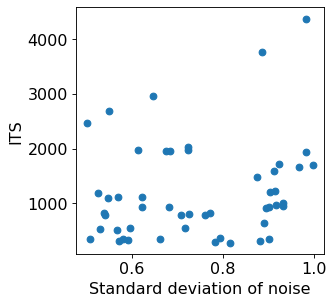

In [32]:
plt.plot(result['config/noise'],result['its_opt'],'o')
plt.xlabel('Standard deviation of noise')
plt.ylabel('ITS')

Text(0, 0.5, 'Optimal MAX_FLIPS')

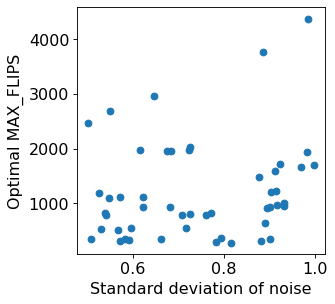

In [33]:
plt.plot(result['config/noise'],result['its_opt'],'o')
plt.xlabel('Standard deviation of noise')
plt.ylabel('Optimal MAX_FLIPS')

Cluster the results by instance and by size and find best noise and best MAX_FLIPS

In [34]:
min_its_instance = result.iloc[result.groupby('config/instance')['its_opt'].idxmin()]
min_its_instance_var = min_its_instance['N']
min_its_instance_noise = min_its_instance['config/noise']
best_noise_size = min_its_instance.groupby('N')['config/noise'].median()
best_max_flips_size = min_its_instance.groupby('N')['max_flips_opt'].median()

Hyperparams can be saved for later use with the scheduler. In this way the scheduler can be loaded for example with instances of different size, and for each size an optimized hp can be found

In [42]:
optimized_hp ={"N_V" : result['N'].unique().tolist(),
"noise" : best_noise_size.tolist(),
"max_flips_median" : best_max_flips_size.tolist(),
"max_flips_max" : (100e3*np.ones(len(best_noise_size))).tolist()}

In [44]:
module_path = os.path.abspath(os.path.join(".."))
filename = module_path+'/data/hp/'+experiment_name+'.json'
# Writing JSON data
with open(filename, 'w') as f:
    json.dump(optimized_hp, f, indent=4)


### Create scheduler configuration with the hyperparameters that we just optimized

In [47]:
configuration = {
    # Heuristic parameters
    "max_runs": 10000,
    "max_flips": 1000,
    "noise_distribution": "normal",
    # HyperParameters. num_samples points between min_noise and max_noise will be generated for each instance in the instance_list
    "hp_location": filename,
    # Experiments parameter
    "p_solve": 0.99,
    "task": "solve",
    "experiment_name": "scheduler_example",
    "instance_list": instances_test[0:10],
}

In [48]:
# Specify the filename
filename = "scheduler_example.json"
filename = module_path+'/config/'+filename
# Writing JSON data
with open(filename, 'w') as f:
    json.dump(configuration, f, indent=4)

### Run scheduler

Open a shell and run<br>
`
python3 countrycrab/scheduler.py --tracking_uri='scheduler_test' --config='config/scheduler_example.json' 
`<br><br>
where `tracking_uri` is the mlflow uri where the experiments will be stored, and `config` the configuration file previously created

### Analyze experiment

In [50]:
module_path = os.path.abspath(os.path.join(".."))
tracking_uri = module_path+'/data/experiments/scheduler_test'
experiment_name = 'scheduler_example'
result = analyze.generate_report(tracking_uri,experiment_name)

2024-02-28 00:54:08,188	INFO experiment_analysis.py:972 -- No trial data passed in during `ExperimentAnalysis` initialization -- you are most likely loading the experiment after it has completed.
Loading trial data from the experiment checkpoint file. This may result in loading some stale information, since checkpointing is periodic.
2024-02-28 00:54:08,222	INFO experiment_analysis.py:972 -- No trial data passed in during `ExperimentAnalysis` initialization -- you are most likely loading the experiment after it has completed.
Loading trial data from the experiment checkpoint file. This may result in loading some stale information, since checkpointing is periodic.
2024-02-28 00:54:08,230	WARNING experiment_analysis.py:916 -- Failed to read the results for 10 trials:
- /home/pedretti/projects/CountryCrab/data/experiments/scheduler_test/0/ba62ebd2b517436bb631878ba6f1fbc2/artifacts/scheduler_example/solve_f356a_00000_0_instance=home_pedretti_projects_CountryCrab_data_uf20-91_uf20-0201_cnf_

In [51]:
result.head()

,its,time_this_iter_s,done,training_iteration,trial_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/instance,logdir
0,946.803140,1.983884,False,1,1432c_00000,2024-02-28_00-48-30,1709081310,1.983884,14923,CountryCrab-container,172.17.0.3,1.983884,1,/home/pedretti/projects/CountryCrab/data/uf20-...,/home/pedretti/projects/CountryCrab/data/exper...
1,954.748356,1.983915,False,1,1432c_00001,2024-02-28_00-48-30,1709081310,1.983915,14924,CountryCrab-container,172.17.0.3,1.983915,1,/home/pedretti/projects/CountryCrab/data/uf20-...,/home/pedretti/projects/CountryCrab/data/exper...
2,2050.248386,2.551548,False,1,1432c_00002,2024-02-28_00-48-31,1709081311,2.551548,14925,CountryCrab-container,172.17.0.3,2.551548,1,/home/pedretti/projects/CountryCrab/data/uf20-...,/home/pedretti/projects/CountryCrab/data/exper...
3,436.187114,2.502910,False,1,1432c_00003,2024-02-28_00-48-31,1709081311,2.502910,14926,CountryCrab-container,172.17.0.3,2.502910,1,/home/pedretti/projects/CountryCrab/data/uf20-...,/home/pedretti/projects/CountryCrab/data/exper...
4,742.581512,1.984269,False,1,1432c_00004,2024-02-28_00-48-30,1709081310,1.984269,14927,CountryCrab-container,172.17.0.3,1.984269,1,/home/pedretti/projects/CountryCrab/data/uf20-...,/home/pedretti/projects/CountryCrab/data/exper...


Text(0, 0.5, 'ITS$_{99}$')

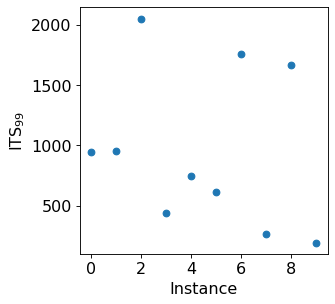

In [53]:
plt.plot(result['its'],'o')
plt.xlabel('Instance')
plt.ylabel('ITS$_{99}$')